# `CLOUD.jl` - 1D linear advection-diffusion example

In [1]:
using OrdinaryDiffEq, CLOUD
ENV["MPLBACKEND"]="agg"
using Plots; pyplot();

Define the physical problem

In [2]:
a = 1.0  # wave speed
b = 1.0e-3  # diffusion coefficient

A = 1.0  # amplitude
L = 1.0  # domain length
σ = 0.1  # width of Gaussian pulse
x₀ = 0.5  # centre of Gaussian pulse
T = 1.0  # end time for one period

initial_data = InitialDataGaussian(A,σ,x₀)
conservation_law = LinearAdvectionDiffusionEquation(a,b);

Set discretization parameters

In [3]:
M = 4
p = 6
form = WeakConservationForm(StandardMapping(),LaxFriedrichsNumericalFlux())
strategy = Lazy()

ode_algorithm = CarpenterKennedy2N54()
dt = 0.1*(L/M)/(a*(2*p+1));
write_interval = floor(Int, T/(dt*10));

Set up a `DGSEM` scheme with LGL quadrature of degree `p` with `M` elements

In [4]:
reference_approximation =ReferenceApproximation(
    DGSEM(p), Line(), volume_quadrature_rule=LGLQuadrature())

mesh = uniform_periodic_mesh(
    reference_approximation.reference_element, (0.0,L), M)

spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation)

results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, (0.0, T), Lazy(),
     "results/advection_diffusion_1d_dgsem/", overwrite=true, clear=true);

Run the solver and plot the solution

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:          177μs / 144086.9%        25.5KiB / 322375.8%   

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 primary variable       10.4k    112ms   43.8%  10.7μs   49.5MiB   61.8%  4.88KiB
   apply operators      10.4k   33.4ms   13.1%  3.21μs   12.5MiB   15.6%  1.23KiB
     volume terms       10.4k   8.48ms    3.3%   815ns   3.81MiB    4.8%     384B
     mass matrix solve  10.4k   4.98ms    2.0%   479ns   2.22MiB    2.8%     224B
     facet terms        10.4k   3.11ms    1.2%   299ns    813KiB    1.0%    80.0B
   eval visc num flux   10.4k   22.5ms    8.8%  2.16μs   9.68MiB   12.1%     976B
   eval flux   

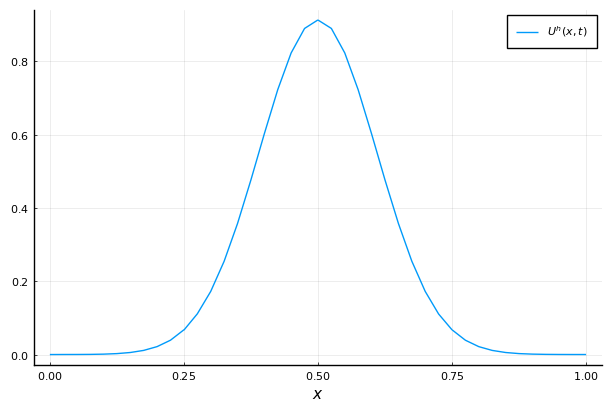

In [7]:
ode_problem = semidiscretize(conservation_law,
    spatial_discretization,
    initial_data, 
    form,
    (0.0, T),
    strategy)
save_solution(ode_problem.u0, 0.0, results_path, 0)
CLOUD_reset_timer()
sol = solve(ode_problem, ode_algorithm, adaptive=false, dt=dt,
    save_everystep=false, callback=save_callback(results_path, write_interval))
CLOUD_print_timer()

save_solution(last(sol.u), last(sol.t), results_path, "final")
plotter = Plotter(spatial_discretization, results_path)
visualize(last(sol.u), plotter, "approx.pdf");

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [8]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

println("L2 error:")
println(analyze(error_analysis, last(sol.u), initial_data)...)
println("Conservation (initial/final/diff):")
println(analyze(conservation_analysis)...)
println("Energy (initial/final/diff):")
println(analyze(energy_analysis)...)

L2 error:
0.03248649764825698
Conservation (initial/final/diff):
[0.2506626716404719][0.2506626716404735][1.609823385706477e-15]
Energy (initial/final/diff):
[0.0886231795493749][0.08090045567521623][-0.007722723874158677]
